# MIMIQ demo - Grover's Algorithm
QPerfect 2025 https://docs.qperfect.io/

Grover's algorithm is a foundational quantum algorithm that offers a quadratic speedup for unstructured search problems. Introduced by Lov Grover in 1996, it efficiently finds a specific item in an unsorted database of size $N$ using only $O(\sqrt{N})$ queries to the database, compared to the $O(N)$ queries required by classical algorithms.

Grover's algorithm has broad applications, including in cryptography, optimization problems, pattern matching and machine learning and quantum complexity theory.

### Problem definition

The standard implementation of Grover's algorithm consists of the following steps:

1. Initialization: Start with a register of $n$ qubits in the $|0\rangle$ state, where $N = 2^n$ is the size of the search space

2. Superposition: Apply Hadamard gates (H) to all qubits, creating a uniform superposition of all possible states

3. Grover Iteration: Repeat the following steps $\sqrt{N}$ times:
   a. Oracle Operation: Apply the phase oracle that marks the target state by flipping its phase
   b. Diffusion Operator: Apply the Grover diffusion operator, which consists of:
      - Hadamard gates on all qubits
      - A conditional phase shift of -1 on all states except $|0\rangle$
      - Hadamard gates on all qubits again

4. Measurement: Measure the qubits in the computational basis to obtain the solution with high probability.

The number of iterations is typically chosen to be $\lfloor \pi/4 \cdot \sqrt{N} \rfloor$ which provides the optimal probability of finding the target state.


### MIMIQ implementation
In this demo we will first implement a simple version of Grover's algorithm to identify desired bit string among $2^n$ possible bitstrings.

Let's start by importing the required packages, and connecting to the MIMIQ service

In [1]:
from mimiqcircuits import *
import matplotlib.pyplot as plt
import numpy as np

# create a connection to the MIMIQ server
conn = MimiqConnection()
conn.connect()

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 552/10000 minutes
├── Executions: 681/10000
├── Max time limit is: Infinite
├── Default time limit is: 30 minutes
└── status: open

Lets start by defining Grover's algorithm. The following function takes the number of iterations and an oracle circuit as inputs and generates the full Grover's algorithm.

In [54]:
def grover(iterations, oracle_circ):
    """
    Implement Grover's algorithm.
    
    Args:
    iterations (int): Number of Grover iterations.
    oracle_circ (Circuit): Oracle circuit.
    
    Returns:
    Circuit: The Grover's algorithm quantum circuit.
    """
    nq = oracle_circ.num_qubits()
    circ = Circuit()
    
    # Create the uniform superposition state
    circ.push(GateH(), range(nq))
    
    for _ in range(iterations):
        # Apply the oracle operator
        circ.append(oracle_circ)
        
        # Apply the diffusion operator
        circ.push(Diffusion(nq), *range(nq))
    
    return circ

We can now define the oracle operator. As a simple example we consider a circuit which flips the phase of one or more desired bitstrings, which will serve as our target states. In MIMIQ a phase flip for a desired bitstring can be easily implemented using a multicontrolled-Z gate

In [55]:
def oracle(bitstrings):
    """
    Create an oracle circuit that flips the phase of desired bitstrings.
    
    Args:
    bitstrings (list of BitString): Target bitstrings to mark.
    
    Returns:
    Circuit: Oracle circuit that marks the target states.
    """
    nq = len(bitstrings[0])
    circ = Circuit()

    for bs in bitstrings:
        # Apply X gates where bits are 0
        for i, b in enumerate(bs):
            if not b:
                circ.push(GateX(), i)
        
        # Multi-controlled Z gate
        circ.push(Control(nq-1, GateZ()), *range(nq))
        
        # Uncompute X gates
        for i, b in enumerate(bs):
            if not b:
                circ.push(GateX(),i)
    return circ

Grover search algorithm: target strings [bs"10101010"]


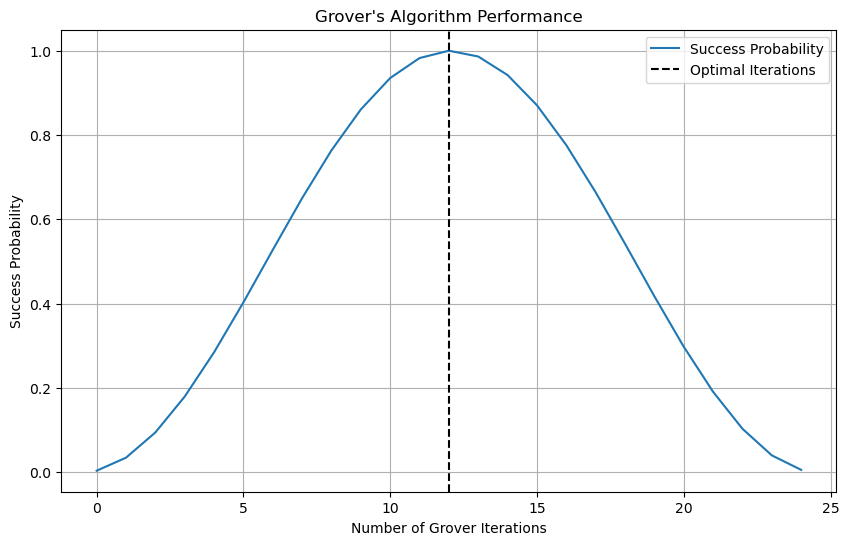

In [57]:
# define parameters
targetstr = [BitString([1,0,1,0,1,0,1,0])]
iterations = range(25)
n, k = len(targetstr[0]), len(targetstr)

# generate circuits and execute
circuits = [grover(i, oracle(targetstr)) for i in iterations]

job = conn.execute(circuits, bitstrings=targetstr, algorithm="statevector")
results = conn.get_results(job)

# Calculate success probabilities
success_probs = [
    [abs(a)**2 for a in r.amplitudes.values()]
    for r in results
]

# estimate the optimal number of iterations
iterations = int(np.floor(np.pi/4*np.sqrt(2**n/k)))

# display results
print(f"Grover search algorithm: target strings {targetstr}")
plt.figure(figsize=(10, 6))
plt.plot(success_probs, label='Success Probability')
plt.axvline(x=iterations, color='k', linestyle='--', label='Optimal Iterations')
plt.xlabel('Number of Grover Iterations')
plt.ylabel('Success Probability')
plt.title("Grover's Algorithm Performance")
plt.legend()
plt.grid(True)
plt.show()

We can also print the results for the optimal number of iterations, which shows a high probability of sampling the target bitstring

In [336]:
results[iterations]

QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── parse time: 0.000279896s
│    ├── apply time: 4.201e-05s
│    ├── total time: 0.000446504s
│    ├── amplitudes time: 6e-07s
│    ├── compression time: 1.824e-05s
│    └── sample time: 5.5689e-05s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    └── bs"10101010" => 1000
├── 1 executions
├── 1 amplitudes
└── 1000 samples

### Pushing the limits with MIMIQ

The oracle in Grover's algorithm is often a source of confusion, particularly since in the preceeding example it seems that the Oracle already contains the solution. However that is not necessary. The oracle in Grover's algorithm serves as a black box that can identify the correct state without revealing it directly. To demonstrate this, we will implement a more advanced oracle which can be used to factor composite integers.

### <center> **For a given integer $N$ we aim to find its factors $p$, $q$ which satisfy $N=pq$.**</center>

However, to date, the best experimental demonstrations of factoring using quantum computers have been limited to very small numbers, e.g., $21=3\times 7$. Thus there is great interest in developing optimized versions of Shor's algorithm and new approaches to quantum factoring which can run on near term quantum computers.

### <center> **In this demo we will implement an optimized factoring algorithm which exploits a quantum search to factor numbers far larger what can be done on any quantum computer today** </center>

## Explanation of the factoring algorithm

We can formulate the factoring problem as a search problem in which we aim to find the factors $p$,$q$ which satisfy 

$$|N - pq| = 0$$

To solve this problem using quantum circuits, we can define three quantum registers $X, Y, Z$ with $n_x, n_y$ and $n_z = n_x + n_y + 1$ qubits respectively. 


The algorithm starts with the $X$ and $Y$ registers initialized in the uniform state. The $Z$ register is initialized in the state $|N\rangle$ where $N$ is the binary representation of the number to be factored. 

This is followed by a loop with $K$ steps, where in each step an Oracle operator is applied to marks the solution state and the diffusion operator from Grover's algorithm is applied to increase the amplitude in the solution state. 

The Oracle can be constructed in three steps:

$$\begin{align}
&|x,y\rangle|z=N\rangle \rightarrow |x,y\rangle|z=N-xy\rangle & \qquad \text{inverse multiplication}\\
&|z=0\rangle \rightarrow -|z=0\rangle & \qquad \text{inverted multicontrol Z gate}\\
&|x,y\rangle|z=N-xy\rangle \rightarrow |x,y\rangle|z=N\rangle & \qquad \text{multiplication}
\end{align}$$

i.e., the state where $N=xy$ will acquire a $\pi$ phase shift while all other states will remain unaffected. 

After $K = \lfloor \frac{\pi}{4}2^{(n_x+n_y)/2} \rfloor$ steps the algorithm converges and the solution can be directly read out by measuring the $X$ and $Y$ registers in the computational basis.

### Circuit primitives

In [2]:
def PhiMultiply(X, Y, Z):
    """
    Acts on three registers to perform the transformation 
    |x,y,z> -> |x,y,z+x*y> in Fourier space
    """
    circ = Circuit()
    nx, ny, nz = len(X), len(Y), len(Z)
    
    # multiplication x*y 
    for j in range(nx):
        for i in range(ny):
            for k in range(i+j, nz):
                angle = 2*np.pi / 2.0**(k - j - i + 1)
                if angle % (2*np.pi) != 0:  # do nothing if angle is multiple of 2pi
                    ctr1, ctr2, target = X[j], Y[i], Z[k]
                    circ.push(Control(2,GateP(angle)), ctr1, ctr2, target)
    return circ

def Multiply(X, Y, Z):
    """
    Performs the operation |x,y,z> -> |x,y,z+xy>
    """
    circ = Circuit()
    nx, ny, nz = len(X), len(Y), len(Z)

    circ.push(QFT(nz), *Z)
    circ.append(PhiMultiply(X, Y, Z))
    circ.push(inverse(QFT(nz)), *Z)
    
    return circ

## Factorizing circuit

In [42]:
def factorize(N: int, K: int, nx: int, ny: int):
    # prepare registers
    nz = nx + ny + 1
    X = list(range(0, nx))
    Y = list(range(nx, nx + ny))
    Z = list(range(nx + ny, nx + ny + nz))
    
    Nj = [int(b) for b in bin(N)[2:][::-1]]  # binary digits of N, least significant first

    # initialize
    circ = Circuit()
    
    circ.push(GateH(), X + Y)
    for j, b in enumerate(Nj):
        if b == 1:
            circ.push(GateX(), Z[j])
    
    # Grover loop
    for k in range(K):
        # Oracle
        #circ.push(PolynomialOracle(nx+ny, nz, 1,0,0,0), *(X+Y+Z))
        circ.append(inverse(Multiply(X, Y, Z)))
        circ.push(GateX(), Z)
        circ.push(Control(nz-1, GateZ()), *Z)
        circ.push(GateX(), Z)
        circ.append(Multiply(X, Y, Z))

        # Diffusion
        circ.push(Diffusion(nx+ny), *(X+Y))
        circ.push(GateRY(-np.pi), X+Y) # this is here to correct a small bug
        
    circ.push(Measure(),X,X)
    return circ

## Inputs

In [1]:
N = 143 # 13 * 11
nx, ny = 4,4

### Run the circuit on the MIMIQ server and sample the outputs

In [44]:
circuit = factorize(N, 8, nx, ny)
# Submit the job
job = conn.execute(circuit, nsamples=100)

# Return the results of the simulation
res = conn.get_result(job, interval=0.1)

[1, 1, 1, 1, 0, 0, 0, 1]


In [45]:
res

QCSResults:
├── simulator: MIMIQ-MPS 0.17.0
├── timings:
│    ├── parse time: 0.006067373s
│    ├── apply time: 31.937144514s
│    ├── total time: 34.148116215s
│    ├── amplitudes time: 3e-07s
│    ├── compression time: 2.199343538s
│    └── sample time: 0.005220513s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 1.78e-08
├── most sampled:
│    ├── bs"1011" => 50
│    └── bs"1101" => 50
├── 1 executions
├── 0 amplitudes
└── 100 samples

## Extract the output bitstrings and integer values

In [46]:
s = res.histogram()
print(list(s.keys()))
[int(ba.to01(), 2) for ba in s.keys()]

[frozenbitarray('1011'), frozenbitarray('1101')]


[11, 13]

### Plot Entanglement Map

In [471]:
def grover(iterations, oracle_circ):
    """
    Implement Grover's algorithm.
    
    Args:
    iterations (int): Number of Grover iterations.
    oracle_circ (Circuit): Oracle circuit.
    
    Returns:
    Circuit: The Grover's algorithm quantum circuit.
    """
    nq = oracle_circ.num_qubits()
    circ = Circuit()
    
    # Create the uniform superposition state
    circ.push(GateH(), range(nq))

    for i in range(iterations):
        # Apply the oracle operator
        circ.append(oracle_circ)
        # Apply the diffusion operator
        circ.push(Diffusion(nq), *range(nq))
        circ.push(VonNeumannEntropy(), range(nq), range(i*nq, i*nq + nq))

    return circ